# CAB420, Practical 4, Question 2 Solution
## Implementing a VGG-Like Network

While AlexNet was the first deep convolutional neural network to get widespread attention, it's performance has since been superseded by many other methods. One such method is [VGG](https://arxiv.org/abs/1409.1556), which is illustrated in the prac sheet.

VGG-16 (and it's slightly larger brother, VGG-19) makes use of smaller, stacked convolution operations. Where AlexNet used large convolution kernels early in the network (the first layer used a $11\times 11$ kernel, VGG-16 uses only $3\times 3$ kernels, yet stacks these in pairs, or sets of three (or sets of four in VGG-19). 

Using the diagrams in the prac sheet as a guide, implement a deep convolution neural network to operate on CIFAR-10 that is inspired by VGG-16. A suggested approach would be:
* A pair of 2D Convolution layers (with an activation between), each with $8$ $3\times 3$ filters, followed by a max pooling layer.
* A pair of 2D Convolution layers (with an activation between), each with $16$ $3\times 3$ filters, followed by a max pooling layer.
* A pair of 2D Convolution layers (with an activation between), each with $32$ $3\times 3$ filters, followed by a max pooling layer.
* Two dense (fully connected) layers, one with $512$ units after the convolution layers, and then a final classification layer with $10$ units.
* Use relu activations throughout, except for your output layer which should use a soft-max layer.

Train and evaluate the network on CIFAR-10, and compare the performance to the earlier trained AlexNet style network. When comparing the networks, also consider the number of parameters in each network, how long the two networks took to train and evaluate, and what was observed with respect to model convergence and overfitting.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

You should also see a lot of similarities between your solution to Question 1 and this question, with the only noteworthy difference being the different network.

### Suggested Packages

TensorFlow and Keras are your friends here. Matplotlib and maybe seaborn will be good for plotting, and sklearn also provides some useful functionality for confusion matricies and accuracy metrics.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy

## Loading the Data

CIFAR-10 is built into keras, so we can load that directly. Note that we will:
* Convert the y-data to categoricals
* Plot some example images as a sanity check

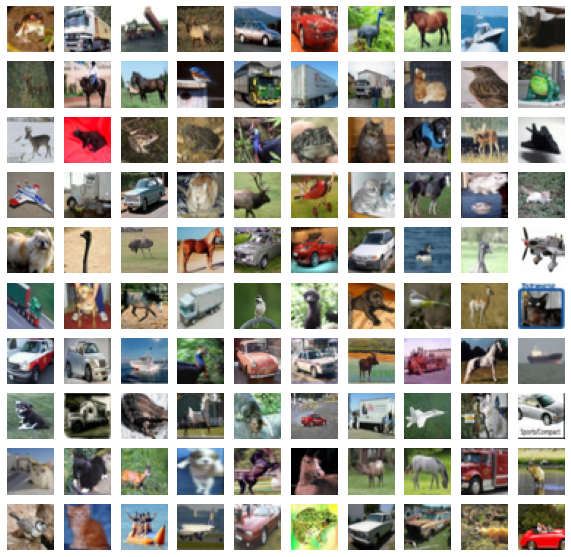

In [2]:
# load the data through the keras API
(train, train_y), (test, test_y) = keras.datasets.cifar10.load_data()

# convert the y-data to categoricals
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

# plot some images
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,:])
    ax.axis('off')

## Building The Network

We'll follow the suggested layout in the prac sheet, but you could increase or decrease the size of the network to suit your own hardware. If you do, aim to keep the relative size of layers the same (i.e. if you increase the number of conv filters in the first layer to 16, double the number of filters in the other layers too).

In [3]:
# network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block, we have two conv layers, and a max-pooling. The conv layers have identical parameters
# and are simply separated by an activation, in our case, relu
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, increase filters, same structure as above, but now with 16 filters
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, further increase filters to 32, again the structure is the same
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 512 neurons
x = layers.Dense(512, activation='relu')(x)

# the output, 10 neurons for 10 classes, and a softmax activation
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                   

Compared to our AlexNet network, we have a very similar number of parameters (about 5,000 more). This is despite have twice the number of convolutional layers. Once again, most of our parameters are in our first dense layer.

## Train the Network

To train the network, we'll use the same approach as Question 1. We'll
* Use categorical cross entropy, as we have a run-of-the-mill amulti-class classification task
* Use Adam with the default parameters
* Train for 12 epochs. We have $50,000$ training samples, and a batch size of $128$, so in one epoch we'll see $\frac{50000}{128} = 391$ batches of data, i.e. $391$ updates to the model. As we would like to get to $\approx 5000$ training iterations, we'll train for 12 epochs.

In [4]:
model_vgg.compile(
    # categorical cross entropy loss
    loss='categorical_crossentropy',
    # adam optimiser
    optimizer=keras.optimizers.Adam(),
    # compute the accuracy metric, in addition to the loss 
    metrics=['accuracy'])

# train the model
# we'll capture the returned history object that will tell us about the training performance
history = model_vgg.fit(train, train_y,
                    batch_size=128,
                    epochs=12,
                    validation_data=(test, test_y), verbose=True)

Epoch 1/12
391/391 [==============================] - 29s 38ms/step - loss: 1.7847 - accuracy: 0.3788 - val_loss: 1.4985 - val_accuracy: 0.4585
Epoch 2/12
391/391 [==============================] - 11s 27ms/step - loss: 1.3867 - accuracy: 0.5035 - val_loss: 1.3289 - val_accuracy: 0.5223
Epoch 3/12
391/391 [==============================] - 11s 28ms/step - loss: 1.2363 - accuracy: 0.5600 - val_loss: 1.2343 - val_accuracy: 0.5619
Epoch 4/12
391/391 [==============================] - 11s 28ms/step - loss: 1.1260 - accuracy: 0.6006 - val_loss: 1.2485 - val_accuracy: 0.5644
Epoch 5/12
391/391 [==============================] - 13s 33ms/step - loss: 1.0424 - accuracy: 0.6336 - val_loss: 1.2000 - val_accuracy: 0.5827
Epoch 6/12
391/391 [==============================] - 12s 30ms/step - loss: 0.9553 - accuracy: 0.6648 - val_loss: 1.1170 - val_accuracy: 0.6081
Epoch 7/12
391/391 [==============================] - 11s 27ms/step - loss: 0.8744 - accuracy: 0.6922 - val_loss: 1.1213 - val_accuracy:

## Evaluation

Evaluate the model, we'll look at
* Training convergence, by exploring the loss and accuracy on the training and validation datea
* Confusion matricies and F1 scores on the training and validation data

### Training Convergence

We'll plot
* Training and validation loss. We'd like to see the loss converge, i.e. the plots flatten out to a constant. We expect there to be a difference between training and validation loss (training loss being slower), but we'd like these two lines to be as close as possible.
* Training and validation accuracy. As with the loss, we'd like to see these converge. We expect the validation accuracy to be below the training accuracy, but again we'd like them to be close.

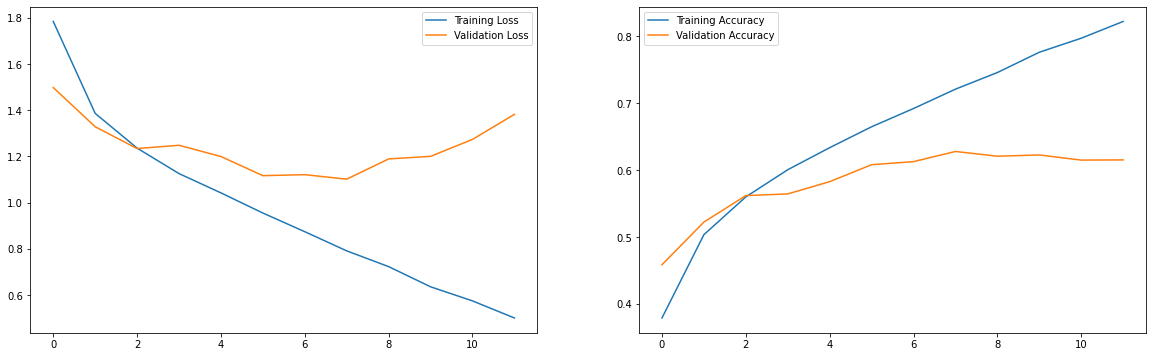

In [5]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

Again we observe overfitting. This is (to my eyes) not as severe or rapid as with our AlexNet like network. Though we should probably still stop training at around 6-8 epochs, and we see that testing performance is far better here than it was with AlexNet.

### Accuracy

We'll plot confusion matrices for the training and testing set, and compute F1 scopes.

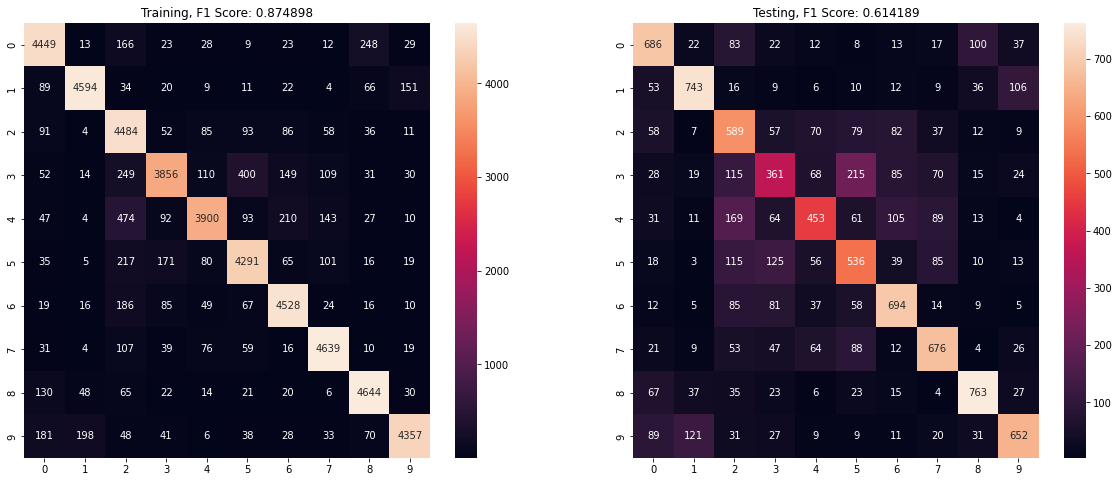

In [6]:
def eval_model(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))
    
eval_model(model_vgg, train, train_y, test, test_y)

This confirms overfitting (if it wasn't confirmed already), but we also see that performance from our VGG-like network is much better than for the AlexNet-like network. 

This is down to the stacked convolutions, which give much greater representive power without a huge increase in parameters.